In [1]:
import numpy as np
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from copy import deepcopy
from utilities import *
from matplotlib import rcParams
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 8,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True, 
    'legend.title_fontsize': 8}
# tell matplotlib about your params
rcParams.update(params)

fig_width_pt = 487.8225/2.3 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*0.9#*ratio  # height in inches
fig_size = [fig_width,2*0.9*fig_width]
rcParams.update({'figure.figsize': fig_size})

In [29]:
sns.set_context("paper")

# Solve pendulum ODE with RK45

In [7]:
f = lambda t,x: np.array([x[1],-np.sin(x[0])])

In [8]:
x0 = np.array([np.pi/4, 0])

In [9]:
T = 20
t = np.linspace(0, T, 200)

In [27]:
sol = solve_ivp(f, (0,T), x0, t_eval = t, method='RK45')

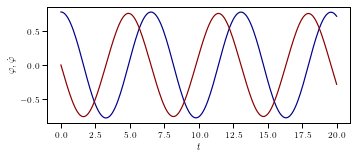

In [8]:
fig = plt.figure()
plt.plot(sol.t, sol.y[0,:], '-', color = 'DarkBlue')
plt.plot(sol.t, sol.y[1,:], '-', color = 'DarkRed')
plt.xlabel(r'$t$')
plt.ylabel(r'$\varphi,\dot{\varphi}$')
plt.tight_layout()
plt.show()

# Using neural ODEs to learn a dynamical system

In [10]:
true_x0 = torch.tensor([[np.pi/4, 0]])
t = torch.linspace(0., T, 200)

Define right-hand side of ODE

In [11]:
class Lambda(nn.Module):

    def forward(self, t, y):
        
        return torch.tensor([y[0,1],-1.0*np.sin(y[0,0])])

Define neural ODE

In [3]:
class ODE_func(nn.Module):

    def __init__(self):
        super(ODE_func, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 10),
            nn.Tanh(),
            nn.Linear(10, 2)
        )

        #for m in self.net.modules():
        #   if isinstance(m, nn.Linear):
        #        nn.init.normal_(m.weight, mean=0, std=0.1)
        #        nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

Generate batches based on observed trajectory

In [4]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = true_x[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_t_2  = t[s]
    batch_x = torch.stack([true_x[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_x0, batch_t, batch_t_2, batch_x

In [12]:
true_x = odeint(Lambda(), true_x0, t, method='dopri5')

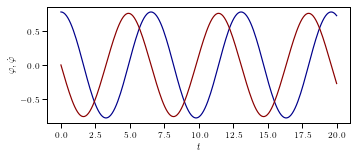

In [14]:
fig = plt.figure()
plt.plot(t, true_x[:,0,0], '-', color = 'DarkBlue')
plt.plot(t, true_x[:,0,1], '-', color = 'DarkRed')
plt.xlabel(r'$t$')
plt.ylabel(r'$\varphi,\dot{\varphi}$')
plt.tight_layout()
plt.show()

In [13]:
data_size = 200
batch_size = 10
batch_time = 10

torch.manual_seed(123)
np.random.seed(123)

func = ODE_func()
optimizer = optim.SGD(func.parameters(), lr=1e-2)
batch_x0, batch_t, batch_t_2, batch_x = get_batch()    
loss_arr_BP = []

best_params_BP = 0
best_loss = 1e9

start = time.time()

itr = 0
end = start

while (end-start) <= 60:
    
    optimizer.zero_grad()
    pred_x = odeint(func, batch_x0, batch_t, method='dopri5')
    loss = torch.mean((pred_x - batch_x)**2)
    loss_arr_BP.append(loss.clone().detach())
    loss.backward()
    optimizer.step()

    if loss < best_loss:
        best_loss = loss
        best_params_BP = deepcopy(func.state_dict())
                       
    end = time.time()
    
    if itr % 100 == 0:
        print(itr,end-start,best_loss)
    
    itr += 1

0 0.02517247200012207 tensor(0.0691, grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

In [62]:
func.load_state_dict(best_params_BP)

<All keys matched successfully>

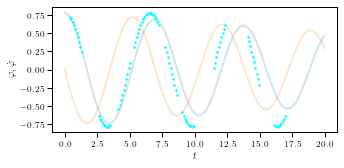

In [63]:
fig = plt.figure()
pred_x = odeint(func, true_x0, t, method='dopri5')

plt.plot(t, pred_x.detach().numpy()[:,0,0], linewidth=2., alpha = 0.2)
plt.plot(t, pred_x.detach().numpy()[:,0,1], linewidth=2., alpha = 0.2)

pred_x = odeint(func, batch_x0, batch_t, method='dopri5')

for i in range(batch_x.size()[1]):
    plt.plot(batch_t_2[i]+batch_t, batch_x.detach().numpy()[:,i,0,0], '.', markersize=3, color='aqua', zorder=10)
#plt.plot(batch_x0.detach().numpy()[:,0,0],batch_x0.detach().numpy()[:,0,1],batch_x0.detach().numpy()[:,0,2], '.', markersize=3, color='tab:red', zorder=10)

plt.xlabel(r'$t$')
plt.ylabel(r'$\varphi,\dot{\varphi}$')

plt.savefig("pendulum.png",dpi=480)
plt.show()

In [66]:
pred_x = odeint(func, batch_x0, batch_t, method='dopri5')
1e4*torch.mean((pred_x - batch_x)**2)

tensor(5.6162, grad_fn=<MulBackward0>)

In [67]:
pred_x = odeint(func, true_x0, t, method='dopri5')
error = 1e2*torch.mean((pred_x - true_x)**2)
print(error)

tensor(8.3780, grad_fn=<MulBackward0>)


# EKI optimization of neural ODEs

In [16]:
# hyperparameters EKI
number_iterations = 40
new_ensemble_members = 6

In [17]:
best_params_EKI = []
loss_arr_EKI = []

torch.manual_seed(123)

ensemble_members = 22
gamma_0 = 1.4
gamma = gamma_0
Gamma = torch.eye(batch_x.flatten().size()[0]) * gamma
y = batch_x.flatten().repeat(ensemble_members)
y = y.reshape(ensemble_members,-1)

best_loss = 1e9
best_params = 0
loss_arr = []

func_enkf = ODE_func()
nn_params = get_weights(func_enkf)

In [30]:
tensorlist_to_tensor(get_weights(func_enkf))

tensor([-0.2883,  0.0234, -0.3512,  0.2667, -0.6025,  0.5183, -0.5140, -0.5622,
        -0.4468,  0.3202, -0.2613,  0.2646, -0.6001, -0.4290, -0.2596, -0.1390,
        -0.5394,  0.4630, -0.1668,  0.2270,  0.5000,  0.1317,  0.1934,  0.6825,
        -0.3189,  0.2240, -0.3146,  0.5053,  0.5647, -0.6519,  0.2699,  0.1510,
         0.1378,  0.1302,  0.2629, -0.0418, -0.2674, -0.0907, -0.2227,  0.0209,
        -0.0590, -0.1696, -0.0288,  0.2996, -0.0249,  0.0100, -0.0493,  0.0497,
         0.2818,  0.1934,  0.1122,  0.0687])

In [31]:
u, G_u = generate_initial_ensemble(ODE_func, batch_x0, batch_t, ensemble_members, solve_oc_problem=False)

In [32]:
loss = torch.mean((G_u-y)**2,axis=1)
min_ind = torch.argmin(loss)
loss = float(loss[min_ind])
#loss = torch.mean(torch.mean((G_u-y)**2,axis=1))
#loss_arr_EKI.append(loss)

n = 0
ntilde = 0

start = time.time()
end = start

while (end-start) <= 60:
    u = update_step(u, G_u, y, Gamma, ensemble_members)

    G_u = compute_F_u(u, ODE_func, batch_x0, batch_t, ensemble_members, solve_oc_problem=False)

    loss = torch.mean((G_u-y)**2,axis=1)
    min_ind = torch.argmin(loss)
    loss = float(loss[min_ind])
    loss_arr_EKI.append(loss)
    #loss = torch.mean(torch.mean((G_u-y)**2,axis=1))
    #loss_arr_EKI.append(loss)

    if loss < best_loss:
        best_loss = loss
        best_params_EKI = u[min_ind]
    
    if n % 2 == 0:
        #print(n,loss,gamma)
        gamma = gamma_0*np.exp(-0.4*ntilde)
        if n >= 28:
            gamma *= 0.3
        Gamma = torch.eye(batch_x.flatten().size()[0]) * gamma

    n += 1
    ntilde += 1
    
    end = time.time()
print(n, end - start, best_loss)

57 60.49140810966492 6.102807788010978e-07


In [21]:
best_params_EKI

tensor([-0.0691,  0.8967,  0.5410, -1.0750, -0.7992, -0.6683, -0.1496,  0.0246,
        -1.2711,  0.1162, -0.1206,  0.6967, -0.3143, -0.6461,  0.2519,  0.0230,
        -1.2770, -0.9245, -0.5987,  0.8861,  0.0920,  0.0696, -0.1921, -1.1548,
         0.1714, -0.4217,  0.2030, -0.0679, -0.1692,  0.5997,  0.4560, -0.2162,
        -0.4540,  0.1484,  0.1128, -0.0294, -0.2142, -0.1260,  0.0328,  0.1469,
         0.6396,  0.0718,  0.2806,  0.0769,  0.5610, -0.0915,  0.7072, -0.3747,
        -0.1546,  0.0385, -0.0216, -0.2245])

In [22]:
updated_params = npvec_to_tensorlist(best_params_EKI,nn_params)
set_weights(func_enkf,updated_params)

In [25]:
pred_x = odeint(func_enkf, true_x0, t, method='dopri5')
error = 1e5*torch.mean((pred_x - true_x)**2)
print(error)

tensor(1.3773, grad_fn=<MulBackward0>)


In [26]:
pred_x = odeint(func_enkf, batch_x0, batch_t, method='dopri5')
1e7*torch.mean((pred_x - batch_x)**2)

tensor(4.0024, grad_fn=<MulBackward0>)

/home/lucasb/anaconda3/envs/inventory/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


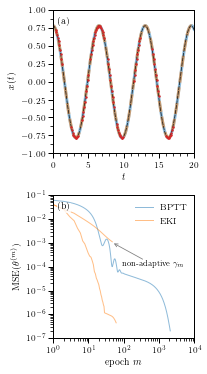

In [31]:
fig = plt.figure(constrained_layout=True)
fig.patch.set_facecolor('white')
mosaic = """
                A
                B
                """
ax_dict = fig.subplot_mosaic(mosaic)

text = ax_dict["A"].text(0.03*20,0.9*2-1,r"(a)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
text = ax_dict["B"].text(1.3,0.024,r"(b)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))

loss_arr_BP = np.loadtxt("data/loss_arr_BP_pendulum.dat")
loss_arr_EKI_no_schedule = np.loadtxt("data/loss_arr_EKI_no_schedule_pendulum.dat")
loss_arr_EKI = np.loadtxt("data/loss_arr_EKI_pendulum.dat")
func.load_state_dict(torch.load("data/BP_pendulum_model.pt"))
func_enkf.load_state_dict(torch.load("data/EKI_pendulum_model.pt"))

pred_x = odeint(func, true_x0, t, method='dopri5')
ax_dict["A"].plot(t, pred_x.detach().numpy()[:,0,0],linewidth=3.,alpha=0.5)

pred_x = odeint(func_enkf, true_x0, t, method='dopri5')
ax_dict["A"].plot(t, pred_x.detach().numpy()[:,0,0],linewidth=3.,alpha=0.5,ls='--')

ax_dict["A"].plot(t, sol.y[0],color="k",alpha=0.8,linewidth=0.8,linestyle=(0, (5, 1)))

for i in range(batch_x.size()[1]):
    ax_dict["A"].plot(batch_t_2[i]+batch_t, batch_x.detach().numpy()[:,i,0,0], '.',color='tab:red',alpha=0.9,markersize=3)

ax_dict["B"].plot(loss_arr_BP,linewidth=1.,alpha=0.5,label=r"BPTT")
ax_dict["B"].plot(loss_arr_EKI,linewidth=1.,alpha=0.5,label=r"EKI")
ax_dict["B"].plot(loss_arr_EKI_no_schedule,linewidth=1.,alpha=0.5,color="tab:orange")
ax_dict["B"].annotate(r"non-adaptive $\gamma_m$", xy=(40, 1.2e-3), xytext=(90, 1e-4),\
                      arrowprops={"arrowstyle":"->", "color":"gray", "shrinkA":0, "shrinkB":5}, fontsize=8)

ax_dict["A"].xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax_dict["A"].yaxis.set_minor_locator(ticker.MultipleLocator(0.125))
ax_dict["A"].set_xlabel(r"$t$")
ax_dict["A"].set_ylabel(r"$x(t)$")
ax_dict["A"].set_xlim([0,20])
ax_dict["A"].set_ylim([-1,1])

ax_dict["B"].legend(loc=1,frameon=False)
ax_dict["B"].set_xlim([1,1e4])
ax_dict["B"].set_ylim([1e-7,1e-1])
ax_dict["B"].set_xscale("log")
ax_dict["B"].set_yscale("log")
ax_dict["B"].set_xlabel(r"epoch $m$")
ax_dict["B"].set_ylabel(r"${\rm MSE}(\theta^{(m)})$")

locmaj = ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax_dict["B"].xaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax_dict["B"].xaxis.set_minor_locator(locmin)
ax_dict["B"].xaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()
plt.savefig("neural_ODE_pendulum_icml.png",dpi=480,bbox_inches='tight',pad_inches = 0)
plt.show()

In [30]:
1.03*1e-6/(5.24*1e-7)

1.9656488549618318

In [49]:
#torch.save(func.state_dict(), "data/BP_pendulum_model.pt")

In [27]:
#torch.save(func_enkf.state_dict(), "data/EKI_pendulum_model.pt")

In [14]:
func.load_state_dict(torch.load("data/BP_pendulum_model.pt"))

<All keys matched successfully>

In [18]:
func_enkf.load_state_dict(torch.load("data/EKI_pendulum_model.pt"))

<All keys matched successfully>

In [19]:
#np.savetxt("data/loss_arr_BP_pendulum.dat",loss_arr_BP)

In [20]:
loss_arr_BP = np.loadtxt("data/loss_arr_BP_pendulum.dat")

In [21]:
loss_arr_EKI_no_schedule = loss_arr_EKI

In [22]:
#np.savetxt("data/loss_arr_EKI_no_schedule_pendulum.dat",loss_arr_EKI_no_schedule)

In [23]:
loss_arr_EKI_no_schedule = np.loadtxt("data/loss_arr_EKI_no_schedule_pendulum.dat")

In [24]:
#np.savetxt("data/loss_arr_EKI_pendulum.dat",loss_arr_EKI)

In [25]:
loss_arr_EKI = np.loadtxt("data/loss_arr_EKI_pendulum.dat")